In [1]:
import numpy as np
import pandas as pd
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20
np.random.seed(12345)
import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))
np.set_printoptions(precision=4, suppress=True)

L’analyse et la modélisation des données demandent beaucoup d’efforts consacrés à la préparation des données : chargement, nettoyage, transformation et réarrangement. On considère que ces tâches représentent 80 % ou plus du travail d’un analyste. Parfois, c’est la manière dont les données sont stockées dans les fichiers ou les bases de données qui n’est pas adaptée à une tâche particulière. De nombreux chercheurs choisissent de faire un traitement ad hoc des données d’un format à un autre en utilisant un langage de programmation général, comme Python, Perl, R ou Java, ou encore des outils de traitement de texte Unix comme sed ou awk. Heureusement, pandas, avec les fonctionnalités natives du langage Python, fournit un ensemble d’outils de haut niveau, souples et rapides, pour manipuler les données dans le bon format. Si vous identifiez un type de manipulation de données qui ne figure nulle part dans ce livre ou ailleurs dans la librairie pandas, n’hésitez pas à partager votre cas d’utilisation spécifique sur l’une des listes de diffusion Python ou sur le dépôt GitHub de pandas. En effet, une grande partie de la conception et de la mise en œuvre de pandas a été dictée par les besoins exprimés pour des applications réelles. Ce chapitre traite des outils dédiés aux données manquantes, aux données en double, à la manipulation des chaînes et à certaines autres transformations de données analytiques. Dans le chapitre suivant, je me concentrerai sur la combinaison et le réarrangement des jeux de données de différentes manières.

# Traitement des données manquantes


Les données manquantes sont fréquentes dans de nombreuses applications d’analyse de données. L’un des objectifs de pandas est de rendre le travail avec les données manquantes aussi indolore que possible. Par exemple, toutes les statistiques descriptives sur les objets pandas excluent par défaut les données manquantes. La manière dont les données manquantes sont représentées dans les objets pandas est quelque peu imparfaite, mais elle est suffit pour de nombreux utilisateurs. Dans le cas des données numériques, pandas représente les données manquantes par la valeur en virgule flottante NaN (Not a Number). Nous appelons cela une valeur sentinelle. Ce type de valeur peut être facilement détecté :

In [2]:
string_data = pd.Series(['aardvark', 'artichoke', np.nan, 'avocado'])
string_data

0     aardvark
1    artichoke
2          NaN
3      avocado
dtype: object

In [3]:
string_data.isnull()

0    False
1    False
2     True
3    False
dtype: bool

Dans pandas, nous avons adopté une convention utilisée dans le langage de programmation R, qui consiste à appeler les données manquantes NA, ce qui se traduit par non disponible. Dans les applications statistiques, les données NA peuvent être soit des données qui n’existent pas, soit des données qui existent mais qui n’ont pas été observées (à cause de problèmes liés à leur collecte, par exemple). Lors du nettoyage des données pour l’analyse, il est souvent important d’étudier les données manquantes elles-mêmes pour d’y identifier les problèmes de collecte ou de biais potentiels provoqués justement par ces données manquantes.

La valeur native None de Python est également traitée en tant que NA dans les tableaux d’objets :

In [4]:
string_data[0] = None
string_data.isnull()

0     True
1    False
2     True
3    False
dtype: bool

## Filtrer les données manquantes

Il existe plusieurs moyens de filtrer les données manquantes. Vous avez toujours la possibilité de le faire à la main avec pandas.isnull et l’indexation booléenne, mais dropna peut être utile. Sur une série, il renvoie l’objet Series avec seulement les données non nulles et les valeurs d’index :

In [5]:
from numpy import nan as NA
data = pd.Series([1, NA, 3.5, NA, 7])
data.dropna()

0    1.0
2    3.5
4    7.0
dtype: float64

Cela équivaut à :

In [6]:
data[data.notnull()]

0    1.0
2    3.5
4    7.0
dtype: float64

Avec les objets DataFrame, les choses sont un peu plus complexes. Vous pouvez vouloir éliminer des lignes ou des colonnes qui sont entièrement NA, ou seulement celles qui contiennent des NA. dropna élimine par défaut toute ligne contenant une valeur manquante :

In [7]:
data = pd.DataFrame([[1., 6.5, 3.], [1., NA, NA],
                     [NA, NA, NA], [NA, 6.5, 3.]])
cleaned = data.dropna()
data

,0,1,2
0,1.0,6.5,3.0
1,1.0,NaN,NaN
2,NaN,NaN,NaN
3,NaN,6.5,3.0


In [8]:
cleaned

,0,1,2
0,1.0,6.5,3.0


Passer how='all' élimine seulement les lignes qui sont entièrement NA :

In [9]:
data.dropna(how='all')

,0,1,2
0,1.0,6.5,3.0
1,1.0,NaN,NaN
3,NaN,6.5,3.0


Pour procéder de la même manière en ce qui concerne les colonnes, passez axis=1 :

In [10]:
data[4] = NA
data

,0,1,2,4
0,1.0,6.5,3.0,NaN
1,1.0,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,6.5,3.0,NaN


In [11]:
data.dropna(axis=1, how='all')

,0,1,2
0,1.0,6.5,3.0
1,1.0,NaN,NaN
2,NaN,NaN,NaN
3,NaN,6.5,3.0


Une autre façon de filtrer les lignes d’un DataFrame concerne en particulier les données de séries chronologiques. Supposons que vous souhaitiez ne conserver que les lignes contenant un certain nombre d’observations. Vous pouvez l’indiquer avec l’argument de seuil thresh :

In [15]:
df = pd.DataFrame(np.random.randn(7, 3))
df.iloc[:4, 1] = NA
df.iloc[:2, 2] = NA
df

,0,1,2
0,0.476985,NaN,NaN
1,-0.577087,NaN,NaN
2,0.523772,NaN,1.343810
3,-0.713544,NaN,-2.370232
4,-1.860761,-0.860757,0.560145
5,-1.265934,0.119827,-1.063512
6,0.332883,-2.359419,-0.199543


In [16]:
df.dropna()

,0,1,2
4,-1.860761,-0.860757,0.560145
5,-1.265934,0.119827,-1.063512
6,0.332883,-2.359419,-0.199543


In [17]:
df.dropna(thresh=2)

,0,1,2
2,0.523772,NaN,1.343810
3,-0.713544,NaN,-2.370232
4,-1.860761,-0.860757,0.560145
5,-1.265934,0.119827,-1.063512
6,0.332883,-2.359419,-0.199543


# Compléter les données manquantes 

Plutôt que de filtrer les données manquantes (risquant ainsi de rejeter d’autres données en même temps), vous pouvez combler les « trous » de différentes manières. Dans la plupart des cas, la méthode fillna est la fonction de base à utiliser. En appelant fillna avec une constante, vous remplacez les données manquantes par cette valeur :

In [18]:
df.fillna(0)

,0,1,2
0,0.476985,0.000000,0.000000
1,-0.577087,0.000000,0.000000
2,0.523772,0.000000,1.343810
3,-0.713544,0.000000,-2.370232
4,-1.860761,-0.860757,0.560145
5,-1.265934,0.119827,-1.063512
6,0.332883,-2.359419,-0.199543


En appelant fillna avec un dict, vous pouvez utiliser une valeur de remplissage différente pour chaque colonne :

In [19]:
df.fillna({1: 0.5, 2: 0})

,0,1,2
0,0.476985,0.500000,0.000000
1,-0.577087,0.500000,0.000000
2,0.523772,0.500000,1.343810
3,-0.713544,0.500000,-2.370232
4,-1.860761,-0.860757,0.560145
5,-1.265934,0.119827,-1.063512
6,0.332883,-2.359419,-0.199543


fillna renvoie un nouvel objet, mais vous pouvez modifier l’objet existant sur place :

In [20]:
_ = df.fillna(0, inplace=True)
df

,0,1,2
0,0.476985,0.000000,0.000000
1,-0.577087,0.000000,0.000000
2,0.523772,0.000000,1.343810
3,-0.713544,0.000000,-2.370232
4,-1.860761,-0.860757,0.560145
5,-1.265934,0.119827,-1.063512
6,0.332883,-2.359419,-0.199543


Les mêmes méthodes d’interpolation disponibles pour la réindexation peuvent être employées avec fillna :

In [21]:
df = pd.DataFrame(np.random.randn(6, 3))
df.iloc[2:, 1] = NA
df.iloc[4:, 2] = NA
df

,0,1,2
0,-1.541996,-0.970736,-1.307030
1,0.286350,0.377984,-0.753887
2,0.331286,NaN,0.069877
3,0.246674,NaN,1.004812
4,1.327195,NaN,NaN
5,0.022185,NaN,NaN


In [22]:
df.fillna(method='ffill')

,0,1,2
0,-1.541996,-0.970736,-1.307030
1,0.286350,0.377984,-0.753887
2,0.331286,0.377984,0.069877
3,0.246674,0.377984,1.004812
4,1.327195,0.377984,1.004812
5,0.022185,0.377984,1.004812


In [23]:
df.fillna(method='ffill', limit=2)

,0,1,2
0,-1.541996,-0.970736,-1.307030
1,0.286350,0.377984,-0.753887
2,0.331286,0.377984,0.069877
3,0.246674,0.377984,1.004812
4,1.327195,NaN,1.004812
5,0.022185,NaN,1.004812


Avec fillna, vous pouvez faire beaucoup d’autres choses avec un peu de créativité. Par exemple, vous pouvez passer la valeur moyenne ou médiane d’une série :

In [24]:
data = pd.Series([1., NA, 3.5, NA, 7])
data.fillna(data.mean())

0    1.000000
1    3.833333
2    3.500000
3    3.833333
4    7.000000
dtype: float64

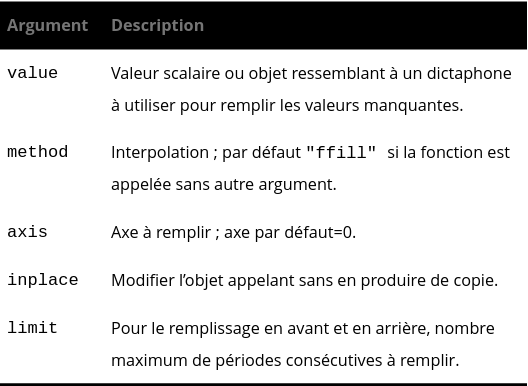

# Transformer les données 

Jusqu’à présent, dans ce chapitre, nous nous sommes préoccupés de la réorganisation des données. Le filtrage, le nettoyage ainsi que d’autres transformations constituent une catégorie différente d’opérations importantes.

## Supprimer les doublons 

Un DataFrame peut afficher des lignes dupliquées pour un certain nombre de raisons. En voici un exemple :

In [25]:
data = pd.DataFrame({'k1': ['one', 'two'] * 3 + ['two'],
                     'k2': [1, 1, 2, 3, 3, 4, 4]})
data

,k1,k2
0,one,1
1,two,1
2,one,2
3,two,3
4,one,3
5,two,4
6,two,4


La méthode duplicated de l’objet DataFrame renvoie une série booléenne indiquant si chaque ligne est un doublon (si elle a été observée dans une ligne précédente) ou non :

In [26]:
data.duplicated()

0    False
1    False
2    False
3    False
4    False
5    False
6     True
dtype: bool

De même, drop_duplicates renvoie un DataFrame correspondant aux cas dans lesquels le tableau duplicated est False :

In [27]:
data.drop_duplicates()

,k1,k2
0,one,1
1,two,1
2,one,2
3,two,3
4,one,3
5,two,4


Ces deux méthodes traitent par défaut toutes les colonnes. Mais vous pouvez également spécifier n’importe quel sous-ensemble de celles-ci pour détecter les doublons. Supposons que nous ayons une colonne de valeurs supplémentaire et que nous voulions filtrer les doublons uniquement sur la base de la colonne 'k1' :

In [28]:
data['v1'] = range(7)
data.drop_duplicates(['k1'])

,k1,k2,v1
0,one,1,0
1,two,1,1


duplicated et drop_duplicates conservent par défaut la première combinaison de valeurs observées. Passer keep='last' renverra la dernière :

In [29]:
data.drop_duplicates(['k1', 'k2'], keep='last')

,k1,k2,v1
0,one,1,0
1,two,1,1
2,one,2,2
3,two,3,3
4,one,3,4
6,two,4,6


# Transformer des données à l’aide d’une fonction ou d’un mappage  

Pour de nombreux jeux de données, vous pouvez souhaiter effectuer une certaine transformation basée sur les valeurs d’un tableau, d’une série ou d’une colonne dans un DataFrame. Considérons par exemple les données hypothétiques suivantes, collectées à partir de différents types de viandes :

In [30]:
data = pd.DataFrame({'food': ['bacon', 'pulled pork', 'bacon',
                              'Pastrami', 'corned beef', 'Bacon',
                              'pastrami', 'honey ham', 'nova lox'],
                     'ounces': [4, 3, 12, 6, 7.5, 8, 3, 5, 6]})
data

,food,ounces
0,bacon,4.0
1,pulled pork,3.0
2,bacon,12.0
3,Pastrami,6.0
4,corned beef,7.5
5,Bacon,8.0
6,pastrami,3.0
7,honey ham,5.0
8,nova lox,6.0


Supposons que vous vouliez ajouter une colonne indiquant le genre d’animal dont provient chaque aliment. Écrivons une correspondance entre chaque type de viande distinct et l’animal correspondant :

In [31]:
meat_to_animal = {
  'bacon': 'pig',
  'pulled pork': 'pig',
  'pastrami': 'cow',
  'corned beef': 'cow',
  'honey ham': 'pig',
  'nova lox': 'salmon'
}

La méthode map d’un objet Series accepte une fonction ou un objet de type dict contenant un mappage, mais ici nous avons un petit problème : certains noms de viandes comprennent des majuscules et d’autres non. Nous devons donc convertir chaque valeur en minuscule avec la méthode de Series str.lower :

In [32]:
lowercased = data['food'].str.lower()
lowercased

0          bacon
1    pulled pork
2          bacon
3       pastrami
4    corned beef
5          bacon
6       pastrami
7      honey ham
8       nova lox
Name: food, dtype: object

In [33]:
data['animal'] = lowercased.map(meat_to_animal)
data

,food,ounces,animal
0,bacon,4.0,pig
1,pulled pork,3.0,pig
2,bacon,12.0,pig
3,Pastrami,6.0,cow
4,corned beef,7.5,cow
5,Bacon,8.0,pig
6,pastrami,3.0,cow
7,honey ham,5.0,pig
8,nova lox,6.0,salmon


Nous aurions également pu passer une fonction faisant tout le travail :

In [34]:
data['food'].map(lambda x: meat_to_animal[x.lower()])

0       pig
1       pig
2       pig
3       cow
4       cow
5       pig
6       cow
7       pig
8    salmon
Name: food, dtype: object

L’utilisation de map est un moyen pratique d’effectuer des transformations élément par élément et d’autres opérations de nettoyage des données.

## Remplacer des valeurs   

Le remplissage des données manquantes avec la méthode fillna est un cas particulier de remplacement de valeurs plus général. Comme vous l’avez déjà vu, map peut être utilisé pour modifier un sous-ensemble de valeurs dans un objet, mais la méthode replace constituera un moyen plus simple et plus souple. Considérez cette série :

In [35]:
data = pd.Series([1., -999., 2., -999., -1000., 3.])
data

0       1.0
1    -999.0
2       2.0
3    -999.0
4   -1000.0
5       3.0
dtype: float64

Les nombres –999 pourraient être des valeurs sentinelles pour les données manquantes. Pour les remplacer par des valeurs NA que pandas comprend, nous pouvons utiliser replace, produisant ainsi une nouvelle série (à moins que vous ne passiez inplace=True) :

In [36]:
data.replace(-999, np.nan)

0       1.0
1       NaN
2       2.0
3       NaN
4   -1000.0
5       3.0
dtype: float64

Si vous voulez remplacer plusieurs valeurs différentes à la fois, vous devrez plutôt passer une liste puis la valeur de substitution :

In [37]:
data.replace([-999, -1000], np.nan)

0    1.0
1    NaN
2    2.0
3    NaN
4    NaN
5    3.0
dtype: float64

Pour utiliser un remplacement différent pour chaque valeur, passez une liste de substituts :

In [38]:
data.replace([-999, -1000], [np.nan, 0])

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

L’argument passé peut aussi être un dict :

In [39]:
data.replace({-999: np.nan, -1000: 0})

0    1.0
1    NaN
2    2.0
3    NaN
4    0.0
5    3.0
dtype: float64

## Détecter et filtrer les valeurs aberrantes  

Le filtrage ou la transformation des valeurs aberrantes (outliers) est en grande partie une question d’application d’opérations sur des tableaux. Considérons un DataFrame avec quelques données normalement distribuées :

In [40]:
data = pd.DataFrame(np.random.randn(1000, 4))
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.053713,0.071633,0.013370,0.004278
std,0.992310,0.993467,1.002853,0.999059
min,-3.428254,-3.548824,-3.184377,-3.745356
25%,-0.758970,-0.591841,-0.660924,-0.633050
50%,-0.111176,0.098240,-0.008947,-0.010997
75%,0.629347,0.780282,0.671128,0.666145
max,3.366626,2.653656,3.260383,3.927528


Supposons que vous vouliez trouver dans l’une des colonnes des valeurs supérieures à 3 en valeur absolue :

In [41]:
col = data[2]
col[np.abs(col) > 3]

87     3.176873
309    3.260383
484   -3.056990
571   -3.184377
Name: 2, dtype: float64

Pour sélectionner toutes les lignes ayant une valeur qui excède 3 ou –3, vous pouvez utiliser la méthode any sur un DataFrame booléen :

In [43]:
data[(data.abs() > 3).any(axis="columns")]

,0,1,2,3
82,-0.774363,0.552936,0.106061,3.927528
87,-0.655054,-0.565230,3.176873,0.959533
290,-2.315555,0.457246,-0.025907,-3.399312
309,0.050188,1.951312,3.260383,0.963301
385,0.146326,0.508391,-0.196713,-3.745356
484,-0.293333,-0.242459,-3.056990,1.918403
508,-3.428254,-0.296336,-0.439938,-0.867165
571,0.275144,1.179227,-3.184377,1.369891
793,-0.362528,-3.548824,1.553205,-2.186301
885,3.366626,-2.372214,0.851010,1.332846


Des valeurs peuvent être fixées sur la base de ces critères. Voici un code permettant de plafonner les valeurs en dehors de l’intervalle de –3 à 3 :

In [44]:
data[np.abs(data) > 3] = np.sign(data) * 3
data.describe()

,0,1,2,3
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.053651,0.072182,0.013174,0.004496
std,0.989744,0.991614,1.000754,0.992016
min,-3.000000,-3.000000,-3.000000,-3.000000
25%,-0.758970,-0.591841,-0.660924,-0.633050
50%,-0.111176,0.098240,-0.008947,-0.010997
75%,0.629347,0.780282,0.671128,0.666145
max,3.000000,2.653656,3.000000,3.000000


L’instruction np.sign(data) produit des valeurs de 1 et –1 selon que les valeurs dans data sont positives ou négatives :

In [45]:
np.sign(data).head()

,0,1,2,3
0,1.0,-1.0,1.0,1.0
1,1.0,-1.0,-1.0,-1.0
2,-1.0,-1.0,-1.0,1.0
3,1.0,1.0,1.0,-1.0
4,-1.0,-1.0,-1.0,1.0


## Permutation et échantillonnage aléatoire  

Permuter (réordonner de manière aléatoire) un objet Series ou les lignes d’un DataFrame est facile à réaliser grâce à la fonction numpy.random.permutation. Appeler permutation avec la longueur de l’axe que vous voulez permuter produit un tableau d’entiers indiquant le nouvel ordre :

In [46]:
df = pd.DataFrame(np.arange(5 * 4).reshape((5, 4)))
sampler = np.random.permutation(5)
sampler

array([3, 2, 1, 0, 4])

Ce tableau peut ensuite être utilisé dans l’indexation basée sur iloc ou la fonction équivalente take :

In [47]:
df

,0,1,2,3
0,0,1,2,3
1,4,5,6,7
2,8,9,10,11
3,12,13,14,15
4,16,17,18,19


In [48]:
df.take(sampler)

,0,1,2,3
3,12,13,14,15
2,8,9,10,11
1,4,5,6,7
0,0,1,2,3
4,16,17,18,19


Pour sélectionner un sous-ensemble aléatoire sans remplacement, vous pouvez utiliser la méthode sample sur Series et DataFrame :

In [49]:
df.sample(n=3)

,0,1,2,3
3,12,13,14,15
4,16,17,18,19
0,0,1,2,3


Pour générer un échantillon avec remplacement (pour permettre des choix répétés), passez replace=True à sample :

In [50]:
choices = pd.Series([5, 7, -1, 6, 4])
draws = choices.sample(n=10, replace=True)
draws

0    5
3    6
0    5
0    5
0    5
4    4
1    7
3    6
4    4
0    5
dtype: int64

## Calculer des variables indicatrices/factices  

Un autre type de transformation pour les applications de modélisation statistique ou d’apprentissage automatique consiste à convertir une variable catégorielle en une matrice « factice » (dummy) ou « indicatrice ». Si une colonne dans un DataFrame a k valeurs distinctes, vous pourriez obtenir une matrice ou un DataFrame avec k colonnes ne contenant que des 1 et des 0. pandas dispose à cet effet d’une fonction get_dummies, bien qu’il ne soit pas difficile d’en concevoir une vous-même. Prenons un exemple de DataFrame :

In [51]:
df = pd.DataFrame({'key': ['b', 'b', 'a', 'c', 'a', 'b'],
                   'data1': range(6)})
pd.get_dummies(df['key'])

,a,b,c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1
4,1,0,0
5,0,1,0


Il est possible d’ajouter un préfixe aux colonnes de l’indicateur DataFrame, qui pourra ensuite être fusionné avec les autres données. get_dummies a un argument prefix à cet effet :

In [52]:
dummies = pd.get_dummies(df['key'], prefix='key')
df_with_dummy = df[['data1']].join(dummies)
df_with_dummy

,data1,key_a,key_b,key_c
0,0,0,1,0
1,1,0,1,0
2,2,1,0,0
3,3,0,0,1
4,4,1,0,0
5,5,0,1,0


Si une ligne dans un DataFrame appartient à plusieurs catégories, les choses sont un peu plus compliquées. Examinons la base de données MovieLens 1M

In [55]:
mnames = ['movie_id', 'title', 'genres']
movies = pd.read_table('datasets/movielens/movies.dat', sep='::',
                       header=None, names=mnames, engine='python')
movies[:10]

,movie_id,title,genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


L’ajout de variables indicatrices pour chaque genre demande un peu de manipulation. Tout d’abord, nous extrayons la liste des genres uniques dans le jeu de données :

In [56]:
all_genres = []
for x in movies.genres:
    all_genres.extend(x.split('|'))
genres = pd.unique(all_genres)

Nous avons maintenant :

In [57]:
genres

array(['Animation', "Children's", 'Comedy', 'Adventure', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror',
       'Sci-Fi', 'Documentary', 'War', 'Musical', 'Mystery', 'Film-Noir',
       'Western'], dtype=object)

Une façon de construire l’indicateur DataFrame consiste à commencer avec un DataFrame rempli de zéros :

In [58]:
zero_matrix = np.zeros((len(movies), len(genres)))
dummies = pd.DataFrame(zero_matrix, columns=genres)

Maintenant, il faut itérer à travers chaque film et mettre à 1 les entrées de chaque ligne de factice. Pour ce faire, nous utilisons factice.columns pour calculer les indices de colonne pour chaque genre :

In [59]:
gen = movies.genres[0]
gen.split('|')
dummies.columns.get_indexer(gen.split('|'))

array([0, 1, 2], dtype=int64)

Nous pouvons utiliser .iloc pour définir des valeurs basées sur ces indices :

In [60]:
for i, gen in enumerate(movies.genres):
    indices = dummies.columns.get_indexer(gen.split('|'))
    dummies.iloc[i, indices] = 1

Ensuite, comme auparavant, vous pouvez combiner cela avec films :

In [61]:
movies_windic = movies.join(dummies.add_prefix('Genre_'))
movies_windic.iloc[0]

movie_id                                      1
title                          Toy Story (1995)
genres              Animation|Children's|Comedy
Genre_Animation                             1.0
Genre_Children's                            1.0
                               ...             
Genre_War                                   0.0
Genre_Musical                               0.0
Genre_Mystery                               0.0
Genre_Film-Noir                             0.0
Genre_Western                               0.0
Name: 0, Length: 21, dtype: object

Une recette utile pour les applications statistiques consiste à combiner get_dummies avec une fonction de discrétisation comme cut :

In [62]:
np.random.seed(12345)
values = np.random.rand(10)
values

array([0.9296, 0.3164, 0.1839, 0.2046, 0.5677, 0.5955, 0.9645, 0.6532,
       0.7489, 0.6536])

In [63]:
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
pd.get_dummies(pd.cut(values, bins))

,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
0,0,0,0,0,1
1,0,1,0,0,0
2,1,0,0,0,0
3,0,1,0,0,0
4,0,0,1,0,0
5,0,0,1,0,0
6,0,0,0,0,1
7,0,0,0,1,0
8,0,0,0,1,0
9,0,0,0,1,0


# Manipuler des chaînes  

Python est depuis longtemps un langage populaire pour la manipulation de données brutes, en partie grâce à sa facilité d’utilisation pour le traitement des chaînes de caractères et des textes. La plupart des opérations sur les textes sont rendues simples grâce aux méthodes natives de l’objet chaîne (string). Pour des manipulations plus complexes de texte et des recherche de motifs, des expressions régulières peuvent être nécessaires. Pour ce faire, pandas permet d’appliquer des expressions régulières de manière concise sur des tableaux de données, en plus de gérer le problème des données manquantes.

## Méthodes pour les objets chaînes  

Dans de nombreuses applications de gestion des chaînes de caractères et de script, les méthodes natives de Python sont suffisantes. Par exemple, une chaîne séparée par des virgules peut être partagée en plusieurs parties avec split :

In [64]:
val = 'a,b,  guido'
val.split(',')

['a', 'b', '  guido']

split est souvent combiné avec strip pour supprimer les espaces vides (y compris les sauts de ligne) :

In [65]:
pieces = [x.strip() for x in val.split(',')]
pieces

['a', 'b', 'guido']

Ces sous-chaînes pourraient être concaténées en y insérant un délimiteur qui utilise l’addition :

In [66]:
first, second, third = pieces
first + '::' + second + '::' + third

'a::b::guido'

Mais ce n’est pas une méthode générique pratique. Une méthode plus rapide et plus « pythonique » consiste à passer une liste ou un tuple à la méthode join de la chaîne ' : : ' :

In [67]:
'::'.join(pieces)

'a::b::guido'

D’autres méthodes concernent la localisation des sous-chaînes. L’utilisation du mot clé in de Python est la meilleure façon de trouver une sous-chaîne, bien que l’on puisse également recourir à index et find :

In [69]:
'guido' in val
val.index(',')

1

In [70]:
val.find(':')

-1

Notez la différence entre find et index : index lève une exception si la chaîne n’est pas trouvée (au lieu de renvoyer –1) :

In [71]:
val.index(':')

ValueError: substring not found

De même, count renvoie le nombre d’occurrences d’une sous-chaîne particulière :

In [72]:
val.count(',')

2

replace remplacera les occurrences d’un motif par un autre. Il est aussi couramment utilisé pour supprimer des motifs en passant une chaîne vide :

In [73]:
val.replace(',', '::')

'a::b::  guido'

In [74]:
val.replace(',', '')

'ab  guido'

Des expressions régulières peuvent également être utilisées pour la plupart de ces opérations, comme vous allez le voir ensuite.

## Expressions régulières

Les expressions régulières offrent un puissant moyen de rechercher, ou de faire correspondre, des motifs de chaînes de caractères (souvent plus complexes) dans le texte. Une expression communément appelée regex est une chaîne de caractères formée conformément au langage des expressions régulières. Le module natif re de Python est chargé de l’application des expressions régulières aux chaînes de caractères. En voici plusieurs exemples.

Les fonctions du module re se répartissent en trois catégories : la correspondance entre motifs, la substitution et le fractionnement. Naturellement, toutes ces fonctions sont liées ; une regex décrit un motif à localiser dans le texte, qui peut ensuite être utilisé à de multiples fins. Prenons un exemple simple. Supposons que nous voulions diviser une chaîne de caractères contenant un nombre variable d’espaces (tabulations, espaces vierges et nouvelles lignes). La regex décrivant un ou plusieurs caractères d’espacement est \s+ :

In [75]:
import re
text = "foo    bar\t baz  \tqux"
re.split('\s+', text)

['foo', 'bar', 'baz', 'qux']

Lorsque vous appelez re.split('\s+', texte), l’expression régulière est d’abord compilée, puis sa méthode split est appelée sur le texte passé en argument. Vous pouvez compiler la regex vous-même avec re.compile afin de former un objet regex réutilisable :

In [76]:
regex = re.compile('\s+')
regex.split(text)

['foo', 'bar', 'baz', 'qux']

Si, au contraire, vous souhaitez obtenir une liste de tous les motifs correspondant à la regex, vous pouvez utiliser la méthode findall :

In [77]:
regex.findall(text)

['    ', '\t ', '  \t']

La création d’un objet regex avec re.compile est fortement recommandée si vous avez l’intention d’appliquer la même expression à de nombreuses chaînes de caractères car cela permettra d’économiser des cycles de CPU.   

match et search sont étroitement liés à findall. Alors que findall renvoie toutes les correspondances dans une chaîne de caractères, search ne renvoie que le premier résultat trouvé. De manière plus stricte, match ne renvoie que les résultats en début de chaîne. À titre d’exemple moins trivial, considérons un bloc de texte et une expression régulière capable d’identifier la plupart des adresses électroniques :

In [78]:
text = """Dave dave@google.com
Steve steve@gmail.com
Rob rob@gmail.com
Ryan ryan@yahoo.com
"""
pattern = r'[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,4}'

# re.IGNORECASE makes the regex case-insensitive
regex = re.compile(pattern, flags=re.IGNORECASE)

L’utilisation de findall sur le texte produit une liste d’adresses de messagerie :

In [79]:
regex.findall(text)

['dave@google.com', 'steve@gmail.com', 'rob@gmail.com', 'ryan@yahoo.com']

search renvoie un objet de correspondance spécial correspondant à la première adresse électronique dans le texte.  

Pour la regex précédente, cet objet ne peut nous indiquer que les positions de début et de fin du motif dans la chaîne :

In [80]:
m = regex.search(text)
m

<re.Match object; span=(5, 20), match='dave@google.com'>

In [81]:
text[m.start():m.end()]

'dave@google.com'

regex.match renvoie None, car il n’y a correspondance que si le motif se trouve au début de la chaîne :

In [82]:
print(regex.match(text))

None


De même, sub renverra une nouvelle chaîne avec les occurrences du motif remplacées par la chaîne spécifiée :

In [83]:
print(regex.sub('REDACTED', text))

Dave REDACTED
Steve REDACTED
Rob REDACTED
Ryan REDACTED



Supposons que vous vouliez trouver des adresses de messagerie et segmenter simultanément chaque adresse en ses trois composantes : nom d’utilisateur, nom de domaine et suffixe de domaine. Pour cela, mettez des parenthèses autour des parties du motif à segmenter :

In [84]:
pattern = r'([A-Z0-9._%+-]+)@([A-Z0-9.-]+)\.([A-Z]{2,4})'
regex = re.compile(pattern, flags=re.IGNORECASE)

L’objet produit par cette regex modifiée renvoie un tuple des composants du motif avec sa méthode groups :

In [85]:
m = regex.match('wesm@bright.net')
m.groups()

('wesm', 'bright', 'net')

findall renvoie une liste de tuples lorsque le motif comprend des groupes :

In [86]:
regex.findall(text)

[('dave', 'google', 'com'),
 ('steve', 'gmail', 'com'),
 ('rob', 'gmail', 'com'),
 ('ryan', 'yahoo', 'com')]

sub a également accès à des groupes dans chaque correspondance en utilisant des symboles spéciaux comme \1 et \2. Le symbole \1 représente le premier groupe qui correspond, \2 au second, et ainsi de suite :

In [87]:
print(regex.sub(r'Username: \1, Domain: \2, Suffix: \3', text))

Dave Username: dave, Domain: google, Suffix: com
Steve Username: steve, Domain: gmail, Suffix: com
Rob Username: rob, Domain: gmail, Suffix: com
Ryan Username: ryan, Domain: yahoo, Suffix: com



# Fonctions de chaîne vectorisées dans pandas  

Le nettoyage d’un jeu de données en désordre pour l’analyse nécessite souvent beaucoup de tâtonnements (munging) et de régularisation. Pour compliquer les choses, une colonne contenant des chaînes de caractères souffrira parfois de données manquantes :

In [88]:
data = {'Dave': 'dave@google.com', 'Steve': 'steve@gmail.com',
        'Rob': 'rob@gmail.com', 'Wes': np.nan}
data = pd.Series(data)
data

Dave     dave@google.com
Steve    steve@gmail.com
Rob        rob@gmail.com
Wes                  NaN
dtype: object

In [89]:
data.isnull()

Dave     False
Steve    False
Rob      False
Wes       True
dtype: bool

Vous pouvez appliquer des méthodes de chaînes et des expressions régulières (en fournissant une fonction lambda ou autre) à chaque valeur en utilisant data.map, mais cela échouera pour les valeurs NA (nulles). Pour faire face à ce problème, Series dispose de méthodes orientées tableaux pour les opérations sur les chaînes de caractères qui « sautent » les valeurs NA. On y accède par l’attribut str des objets Series. Par exemple, nous pourrions vérifier si chaque adresse de messagerie contient 'gmail' avec str.contains :

In [90]:
data.str.contains('gmail')

Dave     False
Steve     True
Rob       True
Wes        NaN
dtype: object

Des expressions régulières peuvent également être utilisées, ainsi que des options de re telles que IGNORECASE :

In [91]:
pattern
data.str.findall(pattern, flags=re.IGNORECASE)

Dave     [(dave, google, com)]
Steve    [(steve, gmail, com)]
Rob        [(rob, gmail, com)]
Wes                        NaN
dtype: object

Il existe plusieurs façons de récupérer des éléments vectorisés. Vous pouvez utiliser str.get, mais aussi spécifier un index par l’attribut str :

In [92]:
matches = data.str.match(pattern, flags=re.IGNORECASE)
matches

Dave     True
Steve    True
Rob      True
Wes       NaN
dtype: object

Vous pouvez enfin trancher des chaînes de caractères en utilisant cette syntaxe :

In [93]:
data.str[:5]

Dave     dave@
Steve    steve
Rob      rob@g
Wes        NaN
dtype: object

# Conclusion  
Une préparation efficace des données peut améliorer considérablement votre productivité en vous permettant de passer plus de temps à analyser les données, et moins à les préparer pour l’analyse. Nous avons exploré un certain nombre d’outils dans ce chapitre, mais cette visite n’est en aucun cas exhaustive. Dans le prochain chapitre, nous explorerons les fonctionnalités de regroupement et de fusion de pandas.